## Imports and variables

In [1]:
#@title Default title text

import pandas as pd
import string, pickle
from wordcloud import WordCloud

from nltk.corpus import stopwords as nltk_stopwords
import pandas as pd
import gensim
import matplotlib.pyplot as plt
import spacy ,re
from tqdm import tqdm


import numpy as np
from tqdm import tqdm
import pyLDAvis, pickle
from pathlib import Path
import datetime, string

from lda import LDA

/Users/umer/opt/anaconda3/envs/CLp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#loading ner models
ner_md = spacy.load("en_core_web_md")
ner_trf = spacy.load("en_core_web_trf")

In [22]:
#Constants

FILEPATH = "data/News_Category_Dataset_v3.json"
BASE_PATH = "/Users/umer/Desktop/UdS winter 22-23/computational linguistics/project/us news/submission/"
NER_OUTPUT_PATH = "ner_output/"

## FUNCTIONS

In [4]:
#read and process data function
def read_data(filepath, isLower=True, isRemovePunc=True, isRemoveStopWords=True, isRemoveNumbers=True):
    df = pd.read_json(FILEPATH, lines=True)
    df = df[df['headline'].notna()]
    df = df[df['short_description'].notna()]
    df = df[df['headline'] != ""]
    df = df[df['short_description'] != ""]

    # data = (df['headline'] + " . " + df['short_description']).tolist()

    # replace the cateogry of the rows whose category is "THE WORLDPOST" with "WORLD NEWS"
    df.loc[df['category'] == "THE WORLDPOST", 'category'] = "WORLD NEWS"
    df.loc[df['category'] == "WORLDPOST", 'category'] = "WORLD NEWS"


    #add a new column to the dataframe which is the concatenation of headline and short description. call it "text"
    df['text'] = df['headline'] + " . " + df['short_description']
    #apply the clean_text function to the text column with arguments isLower, isRemovePunc, isRemoveStopWords, isRemoveNumbers
    df['text'] = df['text'].apply(lambda x: clean_text(x, isLower, isRemovePunc, isRemoveStopWords, isRemoveNumbers))

    return df



In [5]:
#clean_text function

def clean_text(txt, isLower=True, isRemovePunc=True, isRemoveStopWords=True, isRemoveNumbers=True):
    '''
    cleans the corpus. removes the punctuations and numbers. converts all the words to lower case.
    '''
    if isLower:
        txt = txt.lower()

    #replace "\t and \n" with space
    txt = txt.replace("\t", " ")
    txt = txt.replace("\n", " ")
    txt = txt.replace("‘", " ")
    txt = txt.replace("’", " ")
    
    if isRemovePunc:
        txt = txt.translate(str.maketrans('', '', string.punctuation))

    if isRemoveStopWords:
        #remove the stop words and numbers using nltk
        stop_words = set(nltk_stopwords.words('english'))
    if isRemoveNumbers:
        txt = [w for w in txt.split() if not w in stop_words and w.isalpha()]
    

    #remove all extra spaces
    txt = " ".join(txt)
    return txt

In [6]:
# get_ner function
def get_ner(text):
    '''
    returns a dictionary where key is every PERSON entity in the text and value is the count of that entity
    '''
    doc = ner_trf(text)
    ner = {}
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            if ent.text in ner:
                ner[ent.text] += 1
            else:
                ner[ent.text] = 1
    return ner


In [7]:
#get data function 
# function that will get year number and will get the text data for that year
def get_data(df, year=-1, category_column=""):
    if year != -1:
        if category_column=="":
            data = df[df['date'].dt.year == year]
        else:
            data = df[df['date'].dt.year == year]
            data = data[data['category'] == category_column]
    else:
        if category_column=="":
            data = df
        else:
            data = df[df['category'] == category_column]
            
    data = data['text'].tolist()
    return data


In [8]:
#correct_ner_keys
def correct_ner_keys(ner_dict, correct_list, target_name):
    '''
    check the ner dictionary and if any key is in the correct_list then replace that key with target_name.
    the target name key might already exist so we have to add the values of that key and the key we are replacing
    This is done because the data and ner is not perfect and sometimes same person is mentioned with different names.
    '''
    for name in correct_list:
        if name in ner_dict:
            if target_name in ner_dict:
                ner_dict[target_name] += ner_dict[name]
            else:
                ner_dict[target_name] = ner_dict[name]
            del ner_dict[name]

    return ner_dict

In [9]:
#combine_case_sensitive_keys function 
'''
Function to combine all case sensitive keys in the ner dictionary. 
For example key "Donald Trump" and "donald Trump" will be combined into the a new key which will be the same string but lower cased so, "donald trump"
delete the old keys "Donald Trump" and "donald Trump" from the ner dictionary
@args:
    ner_dict: ner dictionary for a particular year
@returns:
    ner_dict: ner dictionary for a particular year with all the case sensitive keys combined into one key
'''
def combine_case_sensitive_keys(ner_dict):
    #get all the keys in the ner dictionary
    ner_dict_keys = list(ner_dict.keys())
    #lower case all the keys in the ner dictionary
    ner_dict_keys_lower = [i.lower() for i in ner_dict_keys]
    new_dict = {}
    #iterate over all the keys in the ner dictionary and fill the new dictionary with the lower case keys and values
    for each_key in ner_dict_keys:
        if each_key.lower() in new_dict:
            new_dict[each_key.lower()] += ner_dict[each_key]
        else:
            new_dict[each_key.lower()] = ner_dict[each_key]
    return new_dict


In [10]:
#Apply NER on politics category of given year

def apply_ner_year_category(year, category):

    #get the data of a particular year and category. save it in a list
    category_year =  get_data(df_ner, year, category)

    #use get_ner function to create a dictionary where key is every PERSON entity in the text and value is the count of that entity.
    # save the dictionary in politics_2016_ner variable
    # do this for the whole politics_2016 list
    #create a dictionary politics_2016_ner which will have key as the entity and value as the count of that entity for the whole politics_2016 list
    category_year_ner = {}
    for text in tqdm(category_year):
        ner_dict = get_ner(text)
        

        for key in ner_dict:
            if key in category_year_ner:
                category_year_ner[key] += ner_dict[key]
            else:
                category_year_ner[key] = ner_dict[key]
                
    #replace the keys "Trump", "Donald Trumps", "Trumps" to "Donald Trump"
    category_year_ner = correct_ner_keys(category_year_ner, ["Trump", "Donald Trumps", "Trumps","Donald"], "Donald Trump")
    #replace the keys "Obama", "Obamas", "Barack Obamas" to "Barack Obama"
    category_year_ner = correct_ner_keys(category_year_ner, ["Obama", "Obamas", "Barack Obamas"], "Barack Obama")
    #replace the keys "Hillary", "Hillarys", "Hillary Clintons", "Hillary","Clinton" to "Hillary Clinton"
    category_year_ner = correct_ner_keys(category_year_ner, ["Hillary", "Hillarys", "Hillary Clintons", "Hillary", "Clinton"], "Hillary Clinton")
    #replace the keys "Cruz", to "Ted Cruz"
    category_year_ner = correct_ner_keys(category_year_ner, ["Cruz"], "Ted Cruz")

    #sort the politics_2016_ner dictionary by value in descending order
    politics_year_ner = dict(sorted(politics_year_ner.items(), key=lambda item: item[1], reverse=True))

    politics_year_ner = combine_case_sensitive_keys(politics_year_ner)

    ner_output_path = BASE_PATH + "ner_output/"
    ner_output_path_file = ner_output_path + category + "_" + str(year) + "_ner.pkl"

    save_pickle(ner_output_path_file,politics_year_ner) 


In [11]:
#analyze_name_entities function
'''
    This function receives a ner dictionary for a particular year and a person name to look for in the ner dictionary. it will use regex to find all the keys in the ner dictionary that matches with the person name. it will then combine all the values of the keys that are found in the ner dictionary and save the result in the ner dictionary. 
    It will return a list of all the keys that are found in the ner dictionary that matches with the person name EXCEPT the person name itself which was passed as a parameter to the function.

    @args:
        politics_year_ner: ner dictionary for a particular year
        person_name_to_look_for: name of the person to look for in the ner dictionary

    @return:
        a list of all the keys that are found in the ner dictionary that matches with the person name EXCEPT the person name itself which was passed as a parameter to the function.

'''
def analyze_name_entities(politics_year_ner, person_name_to_look_for):
    #use regex to get all elements in the list of names_keys_2014 that matches with "trump". lower case the list first.
    names_keys_list = list(politics_year_ner.keys())

    #lower case the person_name_to_look_for and the names_keys_list
    names_keys_list = [i.lower() for i in names_keys_list]
    person_name_to_look_for = person_name_to_look_for.lower()

    found_names = [name for name in names_keys_list if re.search(person_name_to_look_for, name)]

    #remove the person_name_to_look_for from the found_names list
    found_names = [name for name in found_names if name != person_name_to_look_for]

    return found_names



In [12]:
#combine_personalities

'''
@args:
    ner_count_dict: dict , keys are names and values are counts :the ner dictionary for a particular year
    key_to_retain: [string] : the keys to be retained in the ner dictionary. the ith item in key_to_retain will be the sum of the all the items in keys_to_be_replaced[i]
    keys_to_be_replaced: [[string]] : the keys that will be replaced with the key_to_retain. all elements at i in this list are to be replaced with the ith element in key_to_retain. 
@returns:
    the politics_year_ner dictionary with the keys_to_be_replaced replaced with key_to_retain

replace the items at the list i of keys_to_be_replaced with the ith item in keys_to_retain. add the values of the keys_to_be_replaced to the keys_to_retain and then delete the keys_to_be_replaced from the ner dictionary
'''
def combine_personalities(ner_count_dict, keys_to_retain, keys_to_be_replaced):


    #iterate over all the keys in the ner dictionary and fill the new dictionary with the lower case keys and values
    for person_index , each_key_to_be_replaced_outter in enumerate(keys_to_be_replaced):
        for each_key_to_be_replaced in each_key_to_be_replaced_outter:
            if each_key_to_be_replaced in ner_count_dict: #no need to lower case the keys as they are already lower cased when processed earlier
                if keys_to_retain[person_index] in ner_count_dict:
                    ner_count_dict[keys_to_retain[person_index]] += ner_count_dict[each_key_to_be_replaced]
                else:
                    ner_count_dict[keys_to_retain[person_index]] = ner_count_dict[each_key_to_be_replaced]
                del ner_count_dict[each_key_to_be_replaced]

    return ner_count_dict

In [13]:
#save and load pickle function
#function to save a pickle file
def save_pickle(path, obj):
    f = open(path,"wb")
    pickle.dump( obj,f)
    f.close()

def load_pickle(path):
    f = open(path,"rb")
    obj = pickle.load(f)
    return obj

In [23]:
#get_paths function
#function to get the paths of the output files
def get_paths(year=-1, category = ""):
    lda_vis_output_path = BASE_PATH + "lda_vis_output/"
    lda_model_output_path = BASE_PATH + "lda_model_output/"
    
    if year != -1:
        if category == "":
            vis_output_filename = lda_vis_output_path + str(year) +  "_lda.html"
            model_output_filename = lda_model_output_path + str(year) +  "_lda.pickle"
        else:
            vis_output_filename = lda_vis_output_path + str(year) + "_" + category + "_lda.html"
            model_output_filename = lda_model_output_path + str(year) + "_" + category + "_lda.pickle"
    else:
        if category == "":
            vis_output_filename = lda_vis_output_path + "lda.html"
            model_output_filename = lda_model_output_path + "lda.pickle"
        else:
            vis_output_filename = lda_vis_output_path + category + "_lda.html"
            model_output_filename = lda_model_output_path + category + "_lda.pickle"

    return vis_output_filename, model_output_filename


In [24]:
#apply_LDA function
#function that will recieve a list of texts (each text represents a news article) and will
    # apply a LDA model on it and save the model object as pickle and the pyLDAvis object as html file
def apply_LDA(data,year=-1,category="", previousIterationsDone=-1, lda = None):
    if previousIterationsDone==-1:
        lda = LDA("", num_topics=20, num_iterations=500, alpha=0.02, beta=0.1, save_data_iteration=100, 
                  initialize_strategy= "random", read_from_file=False, data=data) 
    
    lda.fit(previousIterationsDone=previousIterationsDone)


    vis_output_filename, model_output_filename = get_paths(year, category)

    #save the lda object as pickle
    save_pickle(model_output_filename, lda)


    lda.visualize(output_html_file_path=vis_output_filename)  

    del lda  

In [27]:
# get Word Cloud function 
def getWordCloud(data):
    #initialize the wordcloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    #join the data into a single string
    long_string = ','.join(data)
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    wordcloud.to_image()

    return wordcloud.to_image()

## Data read

In [14]:
df = read_data(FILEPATH)
columns = df.columns.to_list()
columns

['link',
 'headline',
 'category',
 'short_description',
 'authors',
 'date',
 'text']

In [15]:
#get range of date column in df
df['date'].min(), df['date'].max()

(Timestamp('2012-01-28 00:00:00'), Timestamp('2022-09-23 00:00:00'))

In [ ]:
#get unique values of category column in df
df_columns = df['category'].unique().tolist()
df_columns

# MAIN CODE

## Graphs : General EDA

In [ ]:
#display a graph of number of articles in each category for all years. picture length should be big enough to see the graph properly
df['category'].value_counts().plot(kind='bar', figsize=(20,10))
plt.xlabel("Cateogry", fontsize=10)
plt.ylabel("Number of articles", fontsize=10)
plt.show()


In [ ]:
#bar graph to show the number of articles in each category for the year 2012
df_2012 = df[df['date'].dt.year == 2022]
df_2012['category'].value_counts().plot(kind='bar', figsize=(8,8))
plt.xlabel("Cateogry", fontsize=10)
plt.ylabel("Number of articles", fontsize=10)
plt.show()


In [ ]:
#graph : Category and year wise number of articles

#get the name of top 10 categories mentioned in df
top_n = 5
#get name of the top n categories which appear the most 
top_n_categories = df['category'].value_counts().head(top_n).index.tolist()

#get the counts of top n categories for each year separately. save them in dictionary where key will be the category name and value will be another dictionary with key as year and value as count
# also sort the inner dictionary by year
yearly_count= {}
for category in top_n_categories:
    yearly_count[category] = df[df['category'] == category]['date'].dt.year.value_counts().sort_index().to_dict()


#display the yearly count of each category in a graph.
# use the matplot lib to show the line graph. 
# line colour will be the category. x axis will be the year and y axis will be the count of articles in that year
for category in top_n_categories:
    plt.plot(list(yearly_count[category].keys()), list(yearly_count[category].values()), label=category)
    plt.plot()

plt.legend()
plt.xlabel("Year")
plt.ylabel("Number of articles")
plt.show()


In [ ]:
# hist graph: number of articles in each year
#histogram for number of articles published in each year. x-axis should be year and y-axis should be number of articles. 
# x axis should show labels for all years
# use matplotlib to show the graph and also show the labels on both axis with a big font size
df['date'].dt.year.value_counts().sort_index().plot(kind='bar', figsize=(20,10))
plt.xlabel("Year", fontsize=20)
plt.ylabel("Number of articles", fontsize=20)
plt.show()


In [ ]:
# hist graph: an year's number of articles for each category
#create a histogram for year 2013 for each category. bins in histogram will be the categories.
# x-axis should be the categories and y-axis should be the number of articles
df[df['date'].dt.year == 2022]['category'].value_counts().plot(kind='bar', figsize=(10,5))

## NER

In [ ]:
#Read data from source again for ner 

#get new data without lowering the text because upper case is important for NER to work properly
df_ner = read_data(FILEPATH, isLower=False)

In [ ]:
# Already ran. done run it again. apply_ner_year_category(2021, "POLITICS"). . load from pickle file. this cell takes a lot of time to run

apply_ner_year_category(2014, "POLITICS")
apply_ner_year_category(2015, "POLITICS")
apply_ner_year_category(2016, "POLITICS")
apply_ner_year_category(2017, "POLITICS")
apply_ner_year_category(2018, "POLITICS")
apply_ner_year_category(2019, "POLITICS")
apply_ner_year_category(2020, "POLITICS")
apply_ner_year_category(2021, "POLITICS")
apply_ner_year_category(2022, "POLITICS")


In [337]:
#Politics ner to laod from file
politics_2014_ner = load_pickle(BASE_PATH +  NER_OUTPUT_PATH + "POLITICS_2014_ner.pkl")
politics_2015_ner = load_pickle(BASE_PATH +  NER_OUTPUT_PATH + "POLITICS_2015_ner.pkl")
politics_2016_ner = load_pickle(BASE_PATH +  NER_OUTPUT_PATH + "POLITICS_2016_ner.pkl")
politics_2017_ner = load_pickle(BASE_PATH +  NER_OUTPUT_PATH + "POLITICS_2017_ner.pkl")
politics_2018_ner = load_pickle(BASE_PATH +  NER_OUTPUT_PATH + "POLITICS_2018_ner.pkl")
politics_2019_ner = load_pickle(BASE_PATH +  NER_OUTPUT_PATH + "POLITICS_2019_ner.pkl")
politics_2020_ner = load_pickle(BASE_PATH +  NER_OUTPUT_PATH + "POLITICS_2020_ner.pkl")
politics_2021_ner = load_pickle(BASE_PATH +  NER_OUTPUT_PATH + "POLITICS_2021_ner.pkl")
politics_2022_ner = load_pickle(BASE_PATH +  NER_OUTPUT_PATH + "POLITICS_2022_ner.pkl")



In [ ]:
#use analyze function manually to analyze the names and then filter out the ones that are correct and then pass them to combine_personalities function
persona_name = "warren"
print(analyze_name_entities(politics_2014_ner, persona_name))
print(analyze_name_entities(politics_2015_ner, persona_name))
print(analyze_name_entities(politics_2016_ner, persona_name))
print(analyze_name_entities(politics_2017_ner, persona_name))
print(analyze_name_entities(politics_2018_ner, persona_name))
print(analyze_name_entities(politics_2019_ner, persona_name))
print(analyze_name_entities(politics_2020_ner, persona_name))
print(analyze_name_entities(politics_2021_ner, persona_name))
print(analyze_name_entities(politics_2022_ner, persona_name))

In [349]:
#these lists are created manually by analyzing the output of analyze_name_entities function for each politician
trump_key_to_retain = "donald trump"
trump_keys_to_be_replaced = ['donald trumps inauguration', 'donald trumptrolling', 'donald trumpthemed', 'donald trumps best', 'donald trumpturnberry', 'donald trumprelated' ,'doubtless donald trump' "donald trumpstyle", "donald trump trump", "donald trump trump town", "donald trumpinduced", 'antidonald trump', 'donald trump mccain', 'donald trumps own', 'kareem abduljabbar donald trumps', 'donald trumpkatie', 'donald trump trumps', 'prodonald trump', 'a donald trump' ]

mcconnell_key_to_retain = "mitch mcconnell"
mcconell_keys_to_be_replaced = ["mcconnells","mitch mcconnells","mitch mcconnells handpicked","mitch mcconnells kentucky","mitch mcconnellbacked","mitch mcconnells office","mitch mcconnells super","mitch mcconnells favor","mitch mcconnellaligned","mitch mcconnells chinaperson","mitch mcconnells brotherinlaw"]

warren_key_to_retain = "elizabeth warren"
warren_keys_to_be_replaced = ["elizabeth warrens", "warrens" ]

biden_key_to_retain = "joe biden"
biden_keys_to_be_replaced = ["joe bidens",'beau biden', 'joseph r biden', "bidens", 'moron biden', 'arnold schwarzenegger biden', 'hunter biden', 'beau biden', 'biden putin', "biden", 'frenzy biden']

pelosi_key_to_retain = "nancy pelosi"
pelosi_keys_to_be_replaced = ['nancy pelosis']

cruz_key_to_retain = "ted cruz"
cruz_keys_to_be_replaced = ['ted cruzs', 'ted cruzs true', 'ted cruzs super','ted cruzs cancun', 'ted cruzs','cruzs', 'ted cruzs transphobic' , 'ted cruzjohn','ted cruzs great', 'ted cruzs big' , 'ted cruzs rise','tedcruz', 'ted cruzs presidential', 'ted cruzs citizenship', 'ted cruz obama', 'ted cruzs antiimmigration']

obama_key_to_retain = "barack obama"
obama_keys_to_be_replaced = ['barack obamas', 'bush obama', 'hillary obama',"barack nobamam", 'obamakerry', 'obama castro','obama holder', 'obamacares']


keys_to_retain = [trump_key_to_retain, mcconnell_key_to_retain, warren_key_to_retain, biden_key_to_retain, pelosi_key_to_retain, cruz_key_to_retain, obama_key_to_retain]
keys_to_be_replaced = [trump_keys_to_be_replaced, mcconell_keys_to_be_replaced, warren_keys_to_be_replaced, biden_keys_to_be_replaced, pelosi_keys_to_be_replaced, cruz_keys_to_be_replaced, obama_keys_to_be_replaced]


In [350]:
#combine personalities
politics_2014_ner_new = combine_personalities(politics_2014_ner, keys_to_retain, keys_to_be_replaced )
politics_2015_ner_new = combine_personalities(politics_2015_ner, keys_to_retain, keys_to_be_replaced )
politics_2016_ner_new = combine_personalities(politics_2016_ner, keys_to_retain, keys_to_be_replaced )
politics_2017_ner_new = combine_personalities(politics_2017_ner, keys_to_retain, keys_to_be_replaced )
politics_2018_ner_new = combine_personalities(politics_2018_ner, keys_to_retain, keys_to_be_replaced )
politics_2019_ner_new = combine_personalities(politics_2019_ner, keys_to_retain, keys_to_be_replaced )
politics_2020_ner_new = combine_personalities(politics_2020_ner, keys_to_retain, keys_to_be_replaced )
politics_2021_ner_new = combine_personalities(politics_2021_ner, keys_to_retain, keys_to_be_replaced )
politics_2022_ner_new = combine_personalities(politics_2022_ner, keys_to_retain, keys_to_be_replaced )


In [ ]:
#use analyze function manually to analyze the names and then filter out the ones that are correct and then pass them to combine_personalities function
persona_name = "obama"
print(analyze_name_entities(politics_2014_ner_new, persona_name))
print(analyze_name_entities(politics_2015_ner_new, persona_name))
print(analyze_name_entities(politics_2016_ner_new, persona_name))
print(analyze_name_entities(politics_2017_ner_new, persona_name))
print(analyze_name_entities(politics_2018_ner_new, persona_name))
print(analyze_name_entities(politics_2019_ner_new, persona_name))
print(analyze_name_entities(politics_2020_ner_new, persona_name))
print(analyze_name_entities(politics_2021_ner_new, persona_name))
print(analyze_name_entities(politics_2022_ner_new, persona_name))


##### Now that the data for NER analysis is clean, lets do the analysis

In [371]:
#get the most common personalities across the dataset (across all years) and once we have the names then for each year get the count of each "significant" personality
#and then plot the count of each personality for each year


top_n = 1000

# get the most occuring entities from 2014 to 2022
politics_2014_ner_top = dict(list(politics_2014_ner.items())[:top_n])
politics_2015_ner_top = dict(list(politics_2015_ner.items())[:top_n])
politics_2016_ner_top = dict(list(politics_2016_ner.items())[:top_n])
politics_2017_ner_top = dict(list(politics_2017_ner.items())[:top_n])
politics_2018_ner_top = dict(list(politics_2018_ner.items())[:top_n])
politics_2019_ner_top = dict(list(politics_2019_ner.items())[:top_n])
politics_2020_ner_top = dict(list(politics_2020_ner.items())[:top_n])
politics_2021_ner_top = dict(list(politics_2021_ner.items())[:top_n])
politics_2022_ner_top = dict(list(politics_2022_ner.items())[:top_n])

# get the common entities among all the years
common_entities = set(politics_2014_ner_top.keys()).intersection(set(politics_2015_ner_top.keys()),
                                                                  set(politics_2016_ner_top.keys()),
                                                                    set(politics_2017_ner_top.keys()),
                                                                      set(politics_2018_ner_top.keys()),
                                                                        set(politics_2019_ner_top.keys()),
                                                                          set(politics_2020_ner_top.keys()),
                                                                            set(politics_2021_ner_top.keys()),
                                                                              set(politics_2022_ner_top.keys()))

#get the total number for common entities combined for all years
total_common_entities = {}
for entity in common_entities:
    total_common_entities[entity] = politics_2014_ner_top[entity] + politics_2015_ner_top[entity] + politics_2016_ner_top[entity] + politics_2017_ner_top[entity] + politics_2018_ner_top[entity] + politics_2019_ner_top[entity] + politics_2020_ner_top[entity] + politics_2021_ner_top[entity] + politics_2022_ner_top[entity]

#sort the total_common_entities dictionary by value in descending order
total_common_entities = dict(sorted(total_common_entities.items(), key=lambda item: item[1], reverse=True))

# from the common entities, keep only the entities whose value in total_common_entities is greater than 100
common_entities = [entity for entity in common_entities if total_common_entities[entity] > 100]
total_common_entities

{'donald trump': 11865,
 'barack obama': 1800,
 'joe biden': 635,
 'ted cruz': 574,
 'elizabeth warren': 220,
 'mitch mcconnell': 192,
 'nancy pelosi': 106,
 'mitt romney': 91,
 'vladimir putin': 61}

In [372]:
# get the count of significant entities in each year and store it in a dictionary
common_entities_count = {}
for entity in common_entities:
    common_entities_count[entity] = {}
    common_entities_count[entity]["2014"] = politics_2014_ner_top[entity]
    common_entities_count[entity]["2015"] = politics_2015_ner_top[entity]
    common_entities_count[entity]["2016"] = politics_2016_ner_top[entity]
    common_entities_count[entity]["2017"] = politics_2017_ner_top[entity]
    common_entities_count[entity]["2018"] = politics_2018_ner_top[entity]
    common_entities_count[entity]["2019"] = politics_2019_ner_top[entity]
    common_entities_count[entity]["2020"] = politics_2020_ner_top[entity]
    common_entities_count[entity]["2021"] = politics_2021_ner_top[entity]
    common_entities_count[entity]["2022"] = politics_2022_ner_top[entity]
    


In [373]:
#get the number of articles in year 

In [ ]:
# common_entities_count is a dictionary where key is the entity and value is a dictionary with key as year and value as count of that entity in that year
# plot this dictionary in bar graph. x axis is year and y axis is count of entity in that year. color of line is the entity name
# fig size should be 20, 10
# xticks should be 2014, 2015, 2016, 2021, 2022
# legend should be on the right side of the graph
# title of the graph should be "Common Entities in Politics Category of 2014, 2015, 2016, 2021, 2022"

# common_entities_count is the dictionary with the data
fig, ax = plt.subplots(figsize=(8, 8))

# Iterate over each entity in the dictionary
for entity in common_entities_count:
    # Get the data for the current entity
    data = common_entities_count[entity]
    
    # Extract the years and counts from the data dictionary
    years = list(data.keys())
    counts = list(data.values())
    
    # Plot the data as a bar graph with the entity name as the label
    ax.plot(years, counts, label=entity)
    
# Set the title, x-axis label, and y-axis label
ax.set_title('Number of mentions of each personality across the years')
ax.set_xlabel('Year')
ax.set_ylabel('Count')

# Add a legend to the graph
ax.legend()

# Display the graph
plt.show()




In [375]:
#remove "Donal Trump" from the common_entities_count dictionary because it skewes the plot 
common_entities_count.pop("donald trump", None)

{'2014': 2,
 '2015': 210,
 '2016': 4590,
 '2017': 4604,
 '2018': 1389,
 '2019': 242,
 '2020': 459,
 '2021': 251,
 '2022': 118}

In [ ]:
#plot without "Donald Trump"

# common_entities_count is the dictionary with the data
fig, ax = plt.subplots(figsize=(8, 8))

# Iterate over each entity in the dictionary
for entity in common_entities_count:
    # Get the data for the current entity
    data = common_entities_count[entity]
    
    # Extract the years and counts from the data dictionary
    years = list(data.keys())
    counts = list(data.values())
    
    # Plot the data as a bar graph with the entity name as the label
    ax.plot(years, counts, label=entity)
    
# Set the title, x-axis label, and y-axis label
ax.set_title('Number of mentions of each personality across the years')
ax.set_xlabel('Year')
ax.set_ylabel('Count')

# Add a legend to the graph
ax.legend()

# Display the graph
plt.show()




In [ ]:
#plot the bar graph for total_common_entities which is a dictionary with the total count of each entity across all years
#x-axis is the entity name and y-axis is the total count of the entity across all years

# total_common_entities is the dictionary with the data
plt.figure(figsize=(20,6))
plt.bar(total_common_entities.keys(), total_common_entities.values())
plt.xlabel("Personality")
plt.ylabel("Number of mentions")
plt.title("Number of mentions across all years")


## LDA

In [ ]:
# Apply LDA : Done. Data is saved in the output folder

data = get_data(df)
apply_LDA(data)
del data


In [ ]:
# category_column = "POLITICS"
# for year in range(2020,2023):
#     print("Year: ", year)
#     data = get_data(df, year,category_column)
#     apply_LDA(data,year, category_column)
#     del data

## WordCloud

I did not this add this to the project report because it was already getting too long

/Users/umer/opt/anaconda3/envs/CLp/lib/python3.9/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
/Users/umer/opt/anaconda3/envs/CLp/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/umer/opt/anaconda3/envs/CLp/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/umer/opt/anaconda3/envs/CLp/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

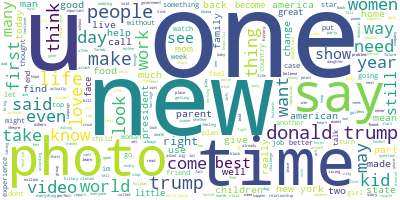

In [26]:
data = get_data(df)
getWordCloud(data)